In [ ]:
# 2018 1)结果

In [2]:
import numpy as np

In [3]:
# 附件1. 专用服装材料的参数值				
# 分层	"密度
# (kg/m）"	"比热
# (J/(kg·ºC))"	"热传导率
# (W/(m·ºC))"	"厚度
# (mm)"
# I层	300	1,377	0.08	0.60
# II层	862	2,100	0.37	0.6-25
# III层	74.20	1,726	0.05	3.60
# IV层	1.18	1,005	0.03	0.6-6.4

In [4]:
rho = np.array([300, 862, 74.20, 1.18])
c = np.array([1377, 2100, 1726, 1005])
k = np.array([0.08, 0.37, 0.05, 0.03])
t = np.array([0.6e-3, 6e-3, 3.6e-3, 5e-3])

In [5]:
dx = 0.01e-3
dt = 0.1

In [6]:
b_ = [0]
for each_t in t:
    b_.append(b_[-1] + int(each_t / dx))
b_

[0, 59, 659, 1018, 1517]

In [7]:
T = 5400
n_ = int(T // dt)
n_

53999

In [8]:
M_B = np.zeros((b_[-1] + 1, b_[-1] + 1))
dt_over_dx_squared = dt / (dx ** 2)
for part in range(1, len(b_)):
    ld = dt_over_dx_squared * k[part - 1] / (c[part - 1] * rho[part - 1])
    for x_ in range(b_[part - 1], b_[part]):
        M_B[x_][x_] = 1 + 2 * ld
        if x_ != 0:
            M_B[x_][x_ - 1] = -ld
        if x_ != b_[-1]:
            M_B[x_][x_ + 1] = -ld
for part, border in enumerate(b_[1:-1]):
    nu_last = k[part]
    nu_next = k[part + 1]
    M_B[border][border] = nu_last + nu_next
    M_B[border][border - 1] = -nu_last
    M_B[border][border + 1] = -nu_next
M_B[0][1] = -1
M_B[-1][-2] = -1
for each in M_B[28:31].tolist():
    print(each[20:40])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -193.65770999757925, 388.3154199951585, -193.65770999757925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -193.65770999757925, 388.3154199951585, -193.65770999757925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -193.65770999757925, 388.3154199951585, -193.65770999757925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [9]:
T_env = 75
T_body = 37
u_0 = None
u_last = None

def set_convection_param(h0, h1):
    mu0 = dx * h0 / k[0]
    mu1 = dx * h1 / k[-1]
    M_B[0][0] = 1 + mu0
    M_B[-1][-1] = 1 + mu1
    global u_0, u_last
    u_0 = mu0 * T_env
    u_last = mu1 * T_body

set_convection_param(118.5, 8.37)

In [10]:
M_B

array([[ 1.01481250e+00, -1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.93657710e+02,  3.88315420e+02, -1.93657710e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.93657710e+02,  3.88315420e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.05954852e+04, -2.52972426e+04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.52972426e+04,  5.05954852e+04, -2.52972426e+04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.00000000e+00,  1.00279000e+00]])

In [11]:
T = np.ndarray((n_, b_[-1] + 1))
T.fill(T_body)

In [12]:
u_0

1.1109375000000001

In [13]:
def cal(h0, h1):
    set_convection_param(h0, h1)
    mask = np.zeros_like(T[0], dtype=bool)
    mask[b_[1:-1]] = True

    M_B_inv = np.linalg.inv(M_B)

    for t_ in range(1, n_):
        # if t_ % int(n_ / 5) == 0:
        #     print(t_ / n_)
        equ_b = T[t_ - 1].copy()
        equ_b[0] = u_0
        equ_b[-1] = u_last
        equ_b[mask] = 0
        T[t_] = M_B_inv @ equ_b
        # T[t_] = np.linalg.solve(M_B, equ_b)
    return T

In [14]:
import pandas as pd

df = pd.read_excel("./d.xlsx")
df.head()

,t,T
0,0,37.0
1,1,37.0
2,2,37.0
3,3,37.0
4,4,37.0


In [15]:
# dt = 0.1, but the interval of df["T"] is 1s
reality = df["T"].to_numpy()

def loss(T):
    # T is a two dimensional array for [time][space]
    # we only want [time][last space]
    return np.sum((T[:, -1][::10] - reality[:-1]) ** 2)

def loss_by_hs(h):
    # h is a two dimensional array
    return loss(cal(h[0], h[1]))

def grad_hs(h):
    eps = 1e-8
    # h is a two dimensional vector, like [100, 20]
    # grad is a two dimensional vector, like [1, 1]
    grad = np.zeros_like(h)
    for i in range(len(h)):
        h1 = h.copy()
        h2 = h.copy()
        h1[i] += eps
        h2[i] -= eps
        grad[i] = (loss_by_hs(h1) - loss_by_hs(h2)) / (2 * eps)
    return grad
        
# perform gradient descent
h = np.array([118.48722172, 8.99325409])
lr = 1e-4
iters = 0

for i in range(iters):
    grad = grad_hs(h)
    #print(grad)
    h -= lr * grad
    l = loss_by_hs(h)
    print(f"Iteration {i}: loss = {l}, h = {h}")
    


# import plotly.graph_objects as go

# # Assuming T is your numpy array with temperature data
# x, y = T.shape
# x_interval = 10
# y_interval = 4
# x_values = list(range(0, x, x_interval))
# y_values = list(range(0, y, y_interval))
# X, Y = np.meshgrid(y_values, x_values)

# fig = go.Figure(data=[go.Surface(z=T[::x_interval, ::y_interval], x=X, y=Y)])
# fig.show()

In [16]:
h

array([118.48722172,   8.99325409])

In [17]:
T = cal(h[0], h[1])

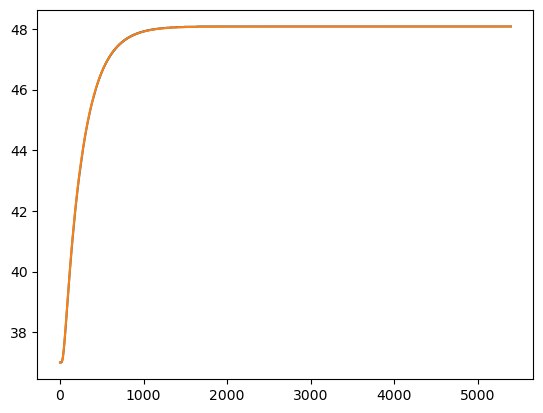

In [20]:
import matplotlib.pyplot as plt

# plot reality
plt.plot(reality, label='data')
plt.plot(T[:, -1][::10], label='prediction')